In [1]:
import time
ini=time.time()
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
def predict(i,RF,md,categories_list,target):
    i.date=i.date.astype(int)
    i[['CO_MES']+categories_list]=i[['CO_MES']+categories_list].astype('category')
    i=pd.get_dummies(i,prefix_sep='~')
    train=i[i.date<i.date.max()]
    test=i[i.date==i.date.max()]
    X_train=train.drop(columns=target)
    
    y_train=train[target]
    X_test=test.drop(columns=target)
    y_test=test[target]
    RF_=RF(max_depth=md)
    RF_.fit(X_train,y_train)
    X_test.insert(0,str(target)+'_test',RF_.predict(X_test))
    X_test.insert(0,str(target),y_test)
    test=X_test
    return test

In [3]:
def fcp(i,categories_list):
    global filtro
    filtro=i[i.date==i.date.max()][['CO_MES']+categories_list].drop_duplicates()
    i=i.merge(filtro)
    return i

In [4]:
i=pd.read_csv('~/git/BD/temp/imp_fert_quanti.csv').sort_values(by=['CO_ANO','CO_MES'])
i=i[i.SG_UF_NCM=='BA']
i=i[i.nick.isin(['UREIA_k','MAP_k','MOP_k','SAM_k'])]
i=i.groupby(by=['CO_ANO','CO_MES','nick'],observed=True)[['KG_LIQUIDO','VL_FOB']].sum()\
.reset_index().sort_values(by=['CO_ANO','CO_MES','nick'])

def sparse_matrix(i, categories_list):
    '''Cria a matriz esparsa'''
    i['date']=pd.to_datetime(i.CO_ANO.astype(str)+'/'+i.CO_MES.astype(str)+'/1')
    i_date_min=i.date.min()
    i_date_max=i.date.max()
    year_range=pd.DataFrame({'CO_ANO':np.arange(i_date_min.year,i_date_max.year+1),'key':0})
    month_range=pd.DataFrame({'CO_MES':np.arange(1,13),'key':0})
    nick_range=pd.DataFrame({'nick':i.nick.unique(),'key':0})
    matrix_range=year_range.merge(month_range).merge(nick_range)
    matrix_range['date']=pd.to_datetime(matrix_range.CO_ANO.astype(str)+'/'+matrix_range.CO_MES.astype(str)+'/1')
    matrix_range=matrix_range[(matrix_range.date>=i_date_min)&(matrix_range.date<=i_date_max)]
    im=i.merge(matrix_range,how='outer').fillna(0).drop(columns='key')
    
    im=im.drop(columns='CO_ANO')
    im['oc']=0
    im.loc[im.KG_LIQUIDO>0,'oc']=1
    return im

In [5]:
i.shape

(911, 5)

In [6]:
categories_list=['nick']
i=sparse_matrix(i, categories_list)

In [7]:
i.shape

(1312, 6)

In [8]:
#def ad_val(i):
w=pd.DataFrame()
a=1
for nick in i.nick.unique():
    it=i[i.nick==nick][['date','KG_LIQUIDO','VL_FOB']].rename(columns={'KG_LIQUIDO':str(nick)+'~kg_ad','VL_FOB':str(nick)+'~fob_ad'})
    if a==1:
        w=it
    else:
        w=w.merge(it,how='outer').fillna(0)
    a+=1

w=w.set_index('date')
w=w.shift(periods=1,freq='MS').reset_index()
w.CO_ANO=w.date.dt.year
w.CO_MES=w.date.dt.month

In [9]:
i=i.merge(w)
i.head(1)

,CO_MES,nick,KG_LIQUIDO,VL_FOB,date,oc,MAP_k~kg_ad,MAP_k~fob_ad,MOP_k~kg_ad,MOP_k~fob_ad,SAM_k~kg_ad,SAM_k~fob_ad,UREIA_k~kg_ad,UREIA_k~fob_ad
0,4,MAP_k,3515344.0,784030.0,1997-04-01,1,0.0,0.0,0.0,0.0,6004584.0,579942.0,0.0,0.0


In [10]:
def test(i,md_c,md_r,categories_list,RFC, RFR,l_min_y=10, indv_list=[0],l_max_y=0, ad_col=[0,1]):

    test_c=pd.DataFrame()
    test_r=pd.DataFrame()
    for indv in indv_list:
        for ad in ad_col:
            it0=i.copy()
            if ad==0:
                it0=it0[it0.columns[~it0.columns.str.contains('~')]]
                        
            while (it0.date.max()-it0.date.min()).days/365.25>=l_min_y:

                if it0[it0.date==it0.date.max()].date.dt.month.values[0]==7:
                    
                    it=it0.copy()
            
                    if l_max_y!=0:
                        it=it[it.date>=it.date.max()-pd.DateOffset(years=l_max_y)]
            
                    if indv==1:
                        it=fcp(it,categories_list)
                    
                    ic=it.drop(columns=['KG_LIQUIDO','VL_FOB'])
                    
                    q2=pd.DataFrame()
                    
                    for mdc in md_c:
                        if indv==0:
                            q1=predict(ic,RFC,mdc,categories_list,'oc').assign(md_c=mdc).assign(l_min_y=l_min_y)\
                            .assign(indv=indv).assign(l_max_y=l_max_y).assign(ad_col=ad).assign(indv=indv)
                            q2=pd.concat([q1,q2])
                        else:
                            ic=fcp(ic,categories_list)
                            for f in filtro.iterrows():
                                ss=pd.DataFrame(ic.loc[f[0],['CO_MES','nick']]).transpose()
                                ic_t=ic.merge(ss)
                                q1=predict(ic_t,RFC,mdc,categories_list,'oc').assign(md_c=mdc).assign(l_min_y=l_min_y)\
                                .assign(indv=indv).assign(l_max_y=l_max_y).assign(ad_col=ad).assign(indv=indv)
                                q2=pd.concat([q1,q2])
                                
                    test_c=pd.concat([q2,test_c]).fillna(False)
                    
                    ir=it[it.KG_LIQUIDO>0].drop(columns=['oc','VL_FOB'])
                   
                    q2=pd.DataFrame()
                    for mdr in md_r:
                        if indv==0:
                            q1=predict(ir,RFR,mdr,categories_list,'KG_LIQUIDO').assign(md_r=mdr).assign(l_min_y=l_min_y)\
                            .assign(indv=indv).assign(l_max_y=l_max_y).assign(ad_col=ad).assign(indv=indv)
                            q2=pd.concat([q1,q2])
                        else:
                            ir=fcp(ir,categories_list)
                            for f in filtro.iterrows():
                                ss=pd.DataFrame(ic.loc[f[0],['CO_MES','nick']]).transpose()
                                ir_t=ir.merge(ss)
                                if len(ir_t)>1:
                                    q1=predict(ir_t,RFR,mdr,categories_list,'KG_LIQUIDO').assign(md_r=mdr).assign(l_min_y=l_min_y)\
                                    .assign(indv=indv).assign(l_max_y=l_max_y).assign(ad_col=ad).assign(indv=indv)
                                    q2=pd.concat([q1,q2])
                                else:
                                    q2=pd.DataFrame()
                    
                    test_r=pd.concat([q2,test_r]).fillna(False)
                
                it0=it0[it0.date<it0.date.max()]

    return test_c,test_r

In [11]:
md_c=[1]
md_r=[1,2,3,5,8,13]
categories_awlist=['nick']
test_c,test_r=test(i,md_c,md_r,categories_list,RFC,RFR,indv_list=[0,1],l_min_y=15,l_max_y=15, ad_col=[0,1])

In [12]:
def un_dumm_sub(test_dumm):
    test=pd.concat([test_dumm.select_dtypes(exclude='bool'),pd.from_dummies(test_dumm.select_dtypes(include='bool'),sep='~')],axis=1)
    test=test[test.columns[~test.columns.str.contains('~')]]
    return test

test_c=un_dumm_sub(test_c)

test_r=un_dumm_sub(test_r)

test=test_c.merge(test_r,how='outer')

test.date=test.date.astype('datetime64[ns]')

test['CO_ANO']=test.date.dt.year


In [13]:
test.to_csv('~/git/BD/temp/test.csv',index=False)

In [14]:
%run 'scores-Copy1.ipynb'

Aprovados:  2


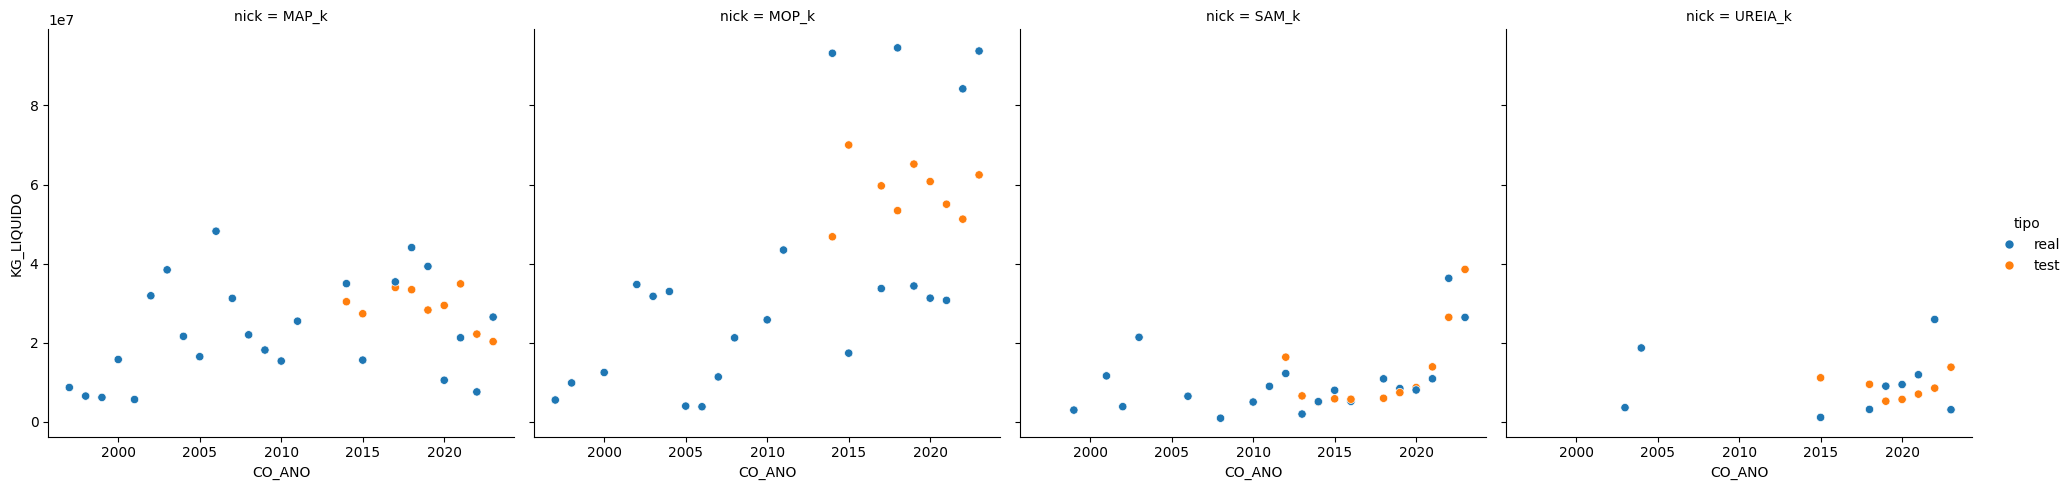

,ad_col,indv,md_r
478,1.0,1.0,1.0
496,0.0,1.0,1.0
1466,0.0,0.0,5.0


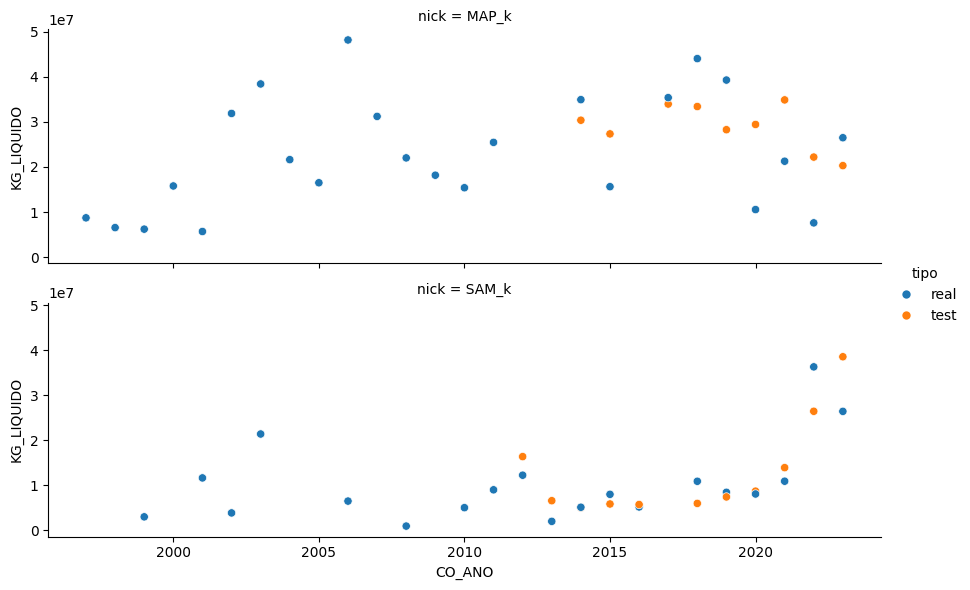

,ad_col,indv,md_r
478,1.0,1.0,1.0
1466,0.0,0.0,5.0


In [15]:
%run 'pred-Copy1.ipynb'

In [16]:
fim=time.time()
print(f"Duração: {round((fim-ini)/60,2)} minutos.")

Duração: 1.54 minutos.
